# Importation et inspection des données

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

In [2]:
#importation des données
import pandas as pd
df = pd.read_excel("./data/heart_weka_only_male.xls")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   disease          209 non-null    object
 1   age              209 non-null    int64 
 2   chest_pain       209 non-null    object
 3   restbpress       209 non-null    int64 
 4   blood_sugar      209 non-null    object
 5   restecg          209 non-null    object
 6   max_hrate        209 non-null    int64 
 7   exercice_angina  209 non-null    object
dtypes: int64(3), object(5)
memory usage: 13.2+ KB


# La méthode DISMIX

### Instanciation, entraînement, classement en resubstitution

In [3]:
# Importation de la classe de Calcul
from discrimintools import DISMIX

# Instanciation
mixdisc = DISMIX(n_components=5,target=["disease"],priors="prop")

# Entrainement - Fit
mixdisc.fit(df)

DISMIX(n_components=5, priors='prop', target=['disease'])

## Stats

In [4]:
# Chi2 test
mixdisc.statistics_["chi2"]

,statistic,ddl,pvalue
chest_pain,78.040932,3,8.075882e-17
exercice_angina,68.893122,1,1.039467e-16
blood_sugar,4.300375,1,3.810397e-02
restecg,3.274817,2,1.944834e-01


In [5]:
# Correlation rtaio - Eta2
mixdisc.statistics_["Eta2"]

,Sum. Intra,Sum. Inter,Eta2,F-stats,pvalue
max_hrate,103207.3503,15373.7501,0.1296,30.8347,0.0000
age,13001.3928,491.3728,0.0364,7.8233,0.0056
restbpress,62434.2467,778.6337,0.0123,2.5816,0.1096


In [6]:
#résultats immédiats - coefficients
mixdisc.coef_

,negative,positive
age,-0.048053,0.061111
restbpress,0.039598,-0.050358
max_hrate,0.103109,-0.131127
asympt,-0.156916,0.199557
atyp_angina,0.167046,-0.212439
non_anginal,0.170482,-0.216809
typ_angina,-0.164976,0.209807
f,0.011424,-0.014529
t,-0.137807,0.175255
left_vent_hyper,0.263634,-0.335273


In [7]:
#intercept
mixdisc.intercept_

,negative,positive
Intercept,-0.877854,-1.302011


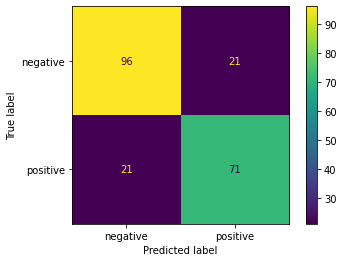

In [8]:
#matrice de confusion en resubstitution
from sklearn import metrics
metrics.ConfusionMatrixDisplay.from_predictions(df.disease,mixdisc.predict(df.iloc[:,1:]))

### Performances en validation croisée

In [9]:
#outil pour la validation croisée
from sklearn.model_selection import StratifiedKFold
cv_splitter = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
cv_splitter.get_n_splits(df.iloc[:,1:],df.disease)

5

In [10]:
#vecteurs pour les résultats
import numpy
effectifs = numpy.zeros(5)
acc = numpy.zeros(5)

#évaluation en validation croisée
for i,(train_index,test_index) in enumerate(cv_splitter.split(df.iloc[:,1:],df.disease)):
    #sous-data frame
    dfTrain = df.iloc[train_index,:]
    dfTest = df.iloc[test_index,:]
    #apprentissage
    dmx = DISMIX(n_components=5,target=["disease"],priors="prop")
    dmx.fit(dfTrain)
    #évaluation
    effectifs[i] = dfTest.shape[0]
    acc[i] = metrics.accuracy_score(dfTest.disease,dmx.predict(dfTest.iloc[:,1:]))

#affichage
print(effectifs)
print(acc)

[42. 42. 42. 42. 41.]
[0.73809524 0.88095238 0.73809524 0.85714286 0.65853659]


In [11]:
#et donc - accuracy en validation croisée
numpy.sum(effectifs*acc)/numpy.sum(effectifs)

0.7751196172248804

# Décryptage de la méthode DISMIX

### Analyse factorielle des données mixtes

In [12]:
#FAMD derrière discmix
mixdisc.factor_model_

FAMD(n_components=5)

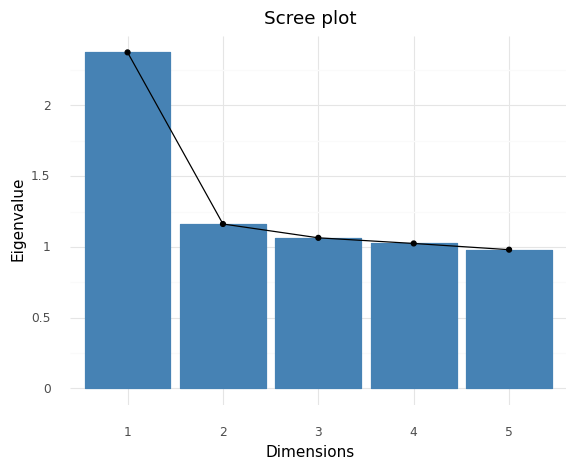

In [13]:
#variance restituée
from scientisttools import fviz_screeplot
p = fviz_screeplot(mixdisc.factor_model_,choice="eigenvalue")
print(p)

In [14]:
#coordonnées factorielles des individus
coord = mixdisc.factor_model_.ind_["coord"]
coord.head(12)

,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5
0,-1.069698,-0.966425,0.071447,0.170056,-1.060476
1,0.876019,-0.898690,-0.368467,-0.498966,-0.337081
2,-0.648692,3.072876,0.430116,-0.108650,0.572960
3,-0.854773,1.004573,-0.671663,0.468576,1.950425
4,0.291900,-0.342568,-0.166640,-0.265184,0.159744
5,0.237483,-0.289115,-0.149369,-0.259315,0.183182
6,2.245878,5.020715,-1.533806,-0.186040,-4.486253
7,2.314921,0.384783,0.439483,0.991553,0.881329
8,0.747094,-0.101416,-0.333469,-0.512404,0.212075
9,2.890754,-0.204545,0.762626,1.649473,0.808793


### Analyse discriminante linéaire

In [15]:
#analyse discriminante
mixdisc.lda_model_

LDA(priors='prop', target=['disease'])

In [16]:
#coefficients de l'hyperplan séparateur
mixdisc.lda_model_.coef_

,negative,positive
Z1,-0.561837,0.714510
Z2,0.199247,-0.253390
Z3,-0.019332,0.024585
Z4,0.467886,-0.595030
Z5,0.143060,-0.181935


In [17]:
#intercept
mixdisc.lda_model_.intercept_

,negative,positive
Intercept,-0.877854,-1.302011
